# Stock price prediction

## Importing libraries

### Pandas

In [2]:
import pandas as pd

### NumPy

In [3]:
import numpy as np

### Matplotlib

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mandates

### SciKit-Learn

In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model

### Keras (Tensorflow)

In [5]:
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import plot_model

## Visualise dataset

### Load dataset

In [6]:
df = pd.read_csv('dataset/nvidia_stock_prices_final.csv', na_values=['null'], index_col='Date', parse_dates=True, infer_datetime_format=True)

C:\Users\Suyash\AppData\Local\Temp\ipykernel_24008\1542505787.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('dataset/nvidia_stock_prices_final.csv', na_values=['null'], index_col='Date', parse_dates=True, infer_datetime_format=True)


### Print dataset's head

In [7]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-22,0.043750,0.048828,0.038802,0.041016,0.037621,2714688000
1999-01-25,0.044271,0.045833,0.041016,0.045313,0.041562,510480000
1999-01-26,0.045833,0.046745,0.041146,0.041797,0.038337,343200000
1999-01-27,0.041927,0.042969,0.039583,0.041667,0.038218,244368000
1999-01-28,0.041667,0.041927,0.041276,0.041536,0.038098,227520000


## Clean dataset

### Display dataset's head

In [8]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-22,0.043750,0.048828,0.038802,0.041016,0.037621,2714688000
1999-01-25,0.044271,0.045833,0.041016,0.045313,0.041562,510480000
1999-01-26,0.045833,0.046745,0.041146,0.041797,0.038337,343200000
1999-01-27,0.041927,0.042969,0.039583,0.041667,0.038218,244368000
1999-01-28,0.041667,0.041927,0.041276,0.041536,0.038098,227520000


### Checking is there is any `null` values

In [9]:
df.isnull().values.any()

False

### Fill the missing values using the mean of the column

In [10]:
df.fillna(df.mean(), inplace=True)

### Double check to see if we filled all the missing values

In [11]:
df.isnull().values.any()

False

## Visualising data

### Plotting the true Adjusted Close value

In [12]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

<Axes: xlabel='Date'>

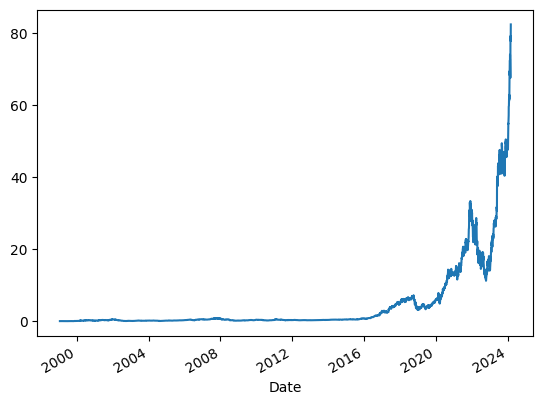

In [13]:
df['Adj Close'].plot()

## Setting the data for the model

### Set up the target variable and the features

In [14]:
# Value of the stock at the end of the day to predict
predict = pd.DataFrame(df['Adj Close'])

# Features to use to predict the value of the stock
features = ['Open', 'High', 'Low', 'Volume']

### Scaling the data

In [15]:
scaler = MinMaxScaler()
features_normalised = scaler.fit_transform(df[features])
features_normalised = pd.DataFrame(columns=features, data=features_normalised, index=df.index)
features_normalised.head()

,Open,High,Low,Volume
Date,,,,
1999-01-22,0.000110,0.000161,0.000069,0.292580
1999-01-25,0.000116,0.000125,0.000097,0.053283
1999-01-26,0.000135,0.000136,0.000098,0.035123
1999-01-27,0.000087,0.000090,0.000079,0.024393
1999-01-28,0.000084,0.000077,0.000100,0.022564


## Training

### Create training set and testing set

In [16]:
timesplit = TimeSeriesSplit(n_splits=10)

for training_index, test_index in timesplit.split(features_normalised):
    X_train, X_test = features_normalised[:len(training_index)], features_normalised[len(training_index): (len(training_index)+len(test_index))]
    y_train, y_test = predict[:len(training_index)].values.ravel(), predict[len(training_index): (len(training_index)+len(test_index))].values.ravel()

### Data processing for LSTM

In [17]:
train_X = np.array(X_train)
test_X = np.array(X_test)

X_train = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
X_test = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

### LSTM preparation

In [18]:
lstm = Sequential()
lstm.add(LSTM(128, activation='relu', input_shape=(1, train_X.shape[1]), return_sequences=False))
lstm.add(Dense(1))
lstm.compile(optimizer='Adam', loss='mse')

c:\Users\Suyash\OneDrive\Desktop\stock-price-prediction-main\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
plot_model(lstm, show_shapes=True, show_layer_names=True)

plot_model(lstm, to_file='model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.
You must install pydot (`pip install pydot`) for `plot_model` to work.


### Model training

In [23]:
history = lstm.fit(X_train, y_train, epochs=100, batch_size=16, shuffle=False, verbose=1)

Epoch 1/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 5.4693e-04
Epoch 2/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0107
Epoch 3/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0131
Epoch 4/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0151
Epoch 5/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0166
Epoch 6/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0167
Epoch 7/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0159
Epoch 8/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0137
Epoch 9/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0113
Epoch 10/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0086
Epoch 11/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0064
Epoch 12/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0046
Epoch 13/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0033
Epoch 14/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0024
Epoch 15/100
359/359 ━━━━━━━━━━━━━━━━━━

## Prediction

In [21]:
y_pred = lstm.predict(X_test)
print(y_pred, y_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
[[30.087097 ]
 [32.914192 ]
 [33.00493  ]
 [34.254494 ]
 [32.0662   ]
 [32.154182 ]
 [32.56711  ]
 [33.154312 ]
 [33.514557 ]
 [33.19903  ]
 [31.994469 ]
 [31.873669 ]
 [29.693321 ]
 [31.843254 ]
 [32.37985  ]
 [31.870358 ]
 [31.105375 ]
 [29.827374 ]
 [28.054996 ]
 [29.198128 ]
 [30.552872 ]
 [28.474804 ]
 [27.520424 ]
 [28.393826 ]
 [29.025778 ]
 [29.853271 ]
 [30.315884 ]
 [31.175793 ]
 [30.193792 ]
 [30.034786 ]
 [29.710842 ]
 [30.284689 ]
 [29.92958  ]
 [28.734974 ]
 [27.706684 ]
 [27.842487 ]
 [26.5779   ]
 [27.338156 ]
 [28.06158  ]
 [27.844885 ]
 [26.434559 ]
 [26.090174 ]
 [25.781574 ]
 [24.789255 ]
 [23.846176 ]
 [22.286255 ]
 [22.417564 ]
 [23.189331 ]
 [22.920116 ]
 [21.875875 ]
 [23.437607 ]
 [24.572538 ]
 [25.29752  ]
 [24.202497 ]
 [23.7934   ]
 [24.333351 ]
 [24.29118  ]
 [25.821543 ]
 [26.102913 ]
 [25.218143 ]
 [23.96994  ]
 [25.455593 ]
 [26.23709  ]
 [25.299185 ]
 [24.27368  ]
 [23.275883 ]
 [23.26754  ]
 [21.849564 ]
 [23.614

## Result plotting and evaluation

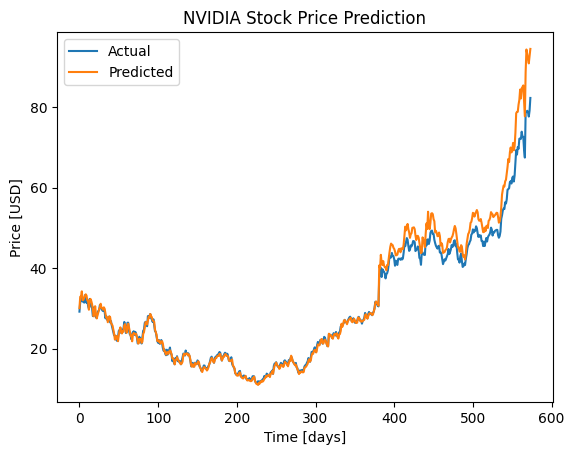

In [22]:
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('NVIDIA Stock Price Prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price [USD]')
plt.legend()
plt.show()